# Example: Custom `MoveStrategy`: RepEx-Shoot-RepEex

One of the powerful features in OpenPathSampling is that it is very easy to develop new Monte Carlo movers for path space. This example shows how easy it is to try out a new type of move. The particular move we use here can be easily described as a simple combination of existing moves, so we don't even need to define a new `PathMover` subclass. We just define a custom `MoveStrategy` that creates the desired `PathMover`, and use that directly.

The idea implemented here is pretty simple. Our standard path movers treat shooting and replica exchange separately, and each move is a single shooting (one ensemble) or a single replica exchange (swap one pair). But maybe you could get better replica exchange behavior by trying all the replica exchange moves, and then trying all the shooting moves. Note that, to satisfy detailed balance, you really have to do all the replica exchange moves, then all the shooting moves, then all the replica exchange moves in the reverse order from before. To measure how this affects travel in replica space, we'll use the replica round trip time (normalized to the total number of shooting moves per ensemble).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np
import openpathsampling.visualize as ops_vis
from IPython.display import SVG

# Set up the simulation

## Set up the engine

In [2]:
import openpathsampling.engines.toy as toys
pes = (toys.OuterWalls([1.0,1.0], [0.0,0.0]) + 
       toys.Gaussian(-0.7, [12.0, 0.5], [-0.5, 0.0]) +
       toys.Gaussian(-0.7, [12.0, 0.5], [0.5, 0.0]))

topology = toys.Topology(n_spatial=2, masses=[1.0, 1.0], pes=pes)

engine = toys.Engine(options={'integ': toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5),
                              'n_frames_max': 5000,
                              'n_steps_per_frame': 10},
                     topology=topology)

template = toys.Snapshot(coordinates=np.array([[0.0, 0.0]]),
                         velocities=np.array([[0.0, 0.0]]),
                         engine=engine)

## Set up CV and volumes (states, interfaces)

In [3]:
# states are volumes in a CV space: define the CV
def xval(snapshot):
    return snapshot.xyz[0][0]

cv = paths.FunctionCV("xval", xval)

stateA = paths.CVDefinedVolume(cv, float("-inf"), -0.5).named("A")
stateB = paths.CVDefinedVolume(cv, 0.5, float("inf")).named("B")
interfaces_AB = paths.VolumeInterfaceSet(cv, float("-inf"), [-0.4, -0.3, -0.2, -0.1])#, 0.0])

## Set up network

In [4]:
network = paths.MISTISNetwork([(stateA, interfaces_AB, stateB)])

## Define a custom strategy

This is the main point of this example: Here we create a custom `MoveStrategy`, which includes the creation of the custom mover. Note that the custom mover itself is quite simple. It takes a bunch of moves that have already been defined, and combines them into a different move.

This is a `GROUP`-level mover, meaning that it only acts after you've already movers in the `SIGNATURE` level. Because of this, all it has to do is to reorganize the movers that already exist.

In [5]:
import openpathsampling.analysis.move_strategy as strategies # TODO: handle this better
# example: custom subclass of `MoveStrategy`
class RepExShootRepExStrategy(strategies.MoveStrategy):
    _level = strategies.levels.GROUP
    # we define an init function mainly to set defaults for `replace` and `group`
    def __init__(self, ensembles=None, group="repex_shoot_repex", replace=True, network=None):
        super(RepExShootRepExStrategy, self).__init__(
            ensembles=ensembles, group=group, replace=replace
        )
            
    def make_movers(self, scheme):
        # if we replace, we remove these groups from the scheme.movers dictionary
        if self.replace:
            repex_movers = scheme.movers.pop('repex')
            shoot_movers = scheme.movers.pop('shooting')
        else:
            repex_movers = scheme.movers['repex']
            shoot_movers = scheme.movers['shooting']
        # combine into a list for the SequentialMover
        mover_list = repex_movers + shoot_movers + list(reversed(repex_movers))
        combo_mover = paths.SequentialMover(mover_list)
        return [combo_mover]

## Create two move schemes: Default and Custom

In [6]:
default_scheme = paths.DefaultScheme(network, engine)

In [7]:
custom_scheme = paths.DefaultScheme(network, engine)
custom_scheme.append(RepExShootRepExStrategy())

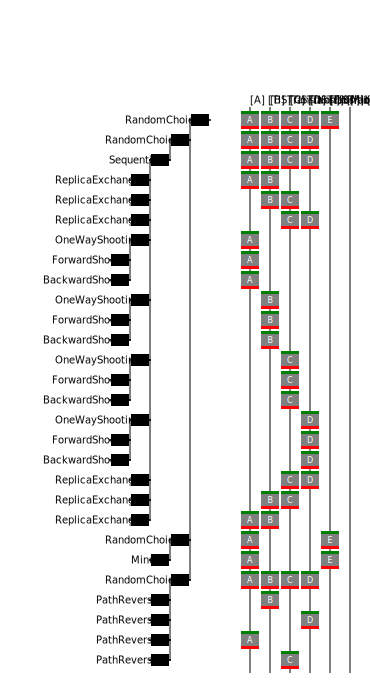

In [8]:
move_vis = ops_vis.MoveTreeBuilder.from_scheme(custom_scheme)
SVG(move_vis.svg())

# Get initial conditions

In [9]:
initial_samples = paths.FullBootstrapping(transition=network.sampling_transitions[0],
                                          snapshot=template,
                                          engine=engine).run()

DONE! Completed Bootstrapping cycle step 40 in ensemble 4/4.


In [10]:
transition = network.sampling_transitions[0]
minus_sample = network.minus_ensembles[0].extend_sample_from_trajectories(
    trajectories=[initial_samples[transition.ensembles[0]].trajectory],
    engine=engine,
    replica=-1
)
initial_samples = initial_samples.apply_samples(minus_sample)

In [11]:
initial_samples.sanity_check()

In [12]:
print "Default Scheme:", default_scheme.initial_conditions_report(initial_samples)
print "Custom Scheme:", custom_scheme.initial_conditions_report(initial_samples)

Default Scheme: No missing ensembles.
No extra ensembles.

Custom Scheme: No missing ensembles.
No extra ensembles.



# Run each of the simulations

In [13]:
n_tries_per_shooting = 10000

In [14]:
# take the number of steps from a single ensemble shooting
n_steps = default_scheme.n_steps_for_trials(
    mover=default_scheme.movers['shooting'][0],
    n_attempts=n_tries_per_shooting
)
n_steps = int(n_steps)+1
print n_steps

77001


In [15]:
default_storage = paths.Storage("default_scheme.nc", "w")

In [16]:
default_calc = paths.PathSampling(
    storage=default_storage,
    sample_set=initial_samples,
    move_scheme=default_scheme
)
default_calc.save_frequency = 100

In [17]:
default_calc.run(n_steps)

Working on Monte Carlo cycle number 77001
Running for 10519 seconds -  7.32 steps per second
Expected time to finish: 0 seconds
DONE! Completed 77001 Monte Carlo cycles.


In [18]:
# in repex_shoot_repex, one move shoots all the ensembles
n_steps = custom_scheme.n_steps_for_trials(
    mover=custom_scheme.movers['repex_shoot_repex'],
    n_attempts=n_tries_per_shooting
)
n_steps = int(n_steps)+1
print n_steps

32001


In [19]:
custom_storage = paths.Storage("custom_scheme.nc", "w")

In [ ]:
custom_calc = paths.PathSampling(
    storage=custom_storage,
    sample_set=initial_samples,
    move_scheme=custom_scheme
)
custom_calc.save_frequency = 100

In [ ]:
custom_calc.run(n_steps)

Working on Monte Carlo cycle number 87
Running for 45 seconds -  1.88 steps per second
Expected time to finish: 16989 seconds


# Analyze the results

In [ ]:
# if loading from stored files (not running the stuff above)
#default_storage = paths.AnalysisStorage("default_scheme.nc")
#custom_storage = paths.AnalysisStorage("custom_scheme.nc")
#default_scheme = default_storage.schemes[0]
#custom_scheme = custom_storage.schemes[0]

## A few checks that we are making a fair comparison

### The scheme should be as expected

Also, the number of path reversal moves and the number of minus moves should be similar in both schemes.

In [ ]:
default_scheme.move_summary(default_storage.steps)

In [ ]:
custom_scheme.move_summary(custom_storage.steps)

### The number of snapshots generated by each should be similar

In [ ]:
print len(default_storage.snapshots), len(custom_storage.snapshots)

### Check that we have about the same number of shooting moves per ensemble for each scheme

In [ ]:
default_scheme.move_summary(default_storage.steps, "shooting")

In [ ]:
custom_scheme.move_summary(custom_storage.steps, "repex_shoot_repex")

## Analyze the output to compare the efficiency

### Count the number of round trips done

In [ ]:
default_repx_net = paths.ReplicaNetwork(default_scheme, default_storage.steps)

In [ ]:
default_trips = default_repx_net.trips(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

In [ ]:
n_default_round_trips = len(default_trips['round'])
print n_default_round_trips

In [ ]:
custom_repx_net = paths.ReplicaNetwork(custom_scheme, custom_storage.steps)

In [ ]:
custom_trips = custom_repx_net.trips(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

In [ ]:
n_custom_round_trips = len(custom_trips['round'])
print n_custom_round_trips

Since the "time" for each round trip is reported as a number of steps, we scale them so that they represent a fraction of the total simulation (making this into a even comparison, since the two simulations require about the same amount of MD.)

In [ ]:
plt.hist(np.array(default_trips['round']) / 77001.0, color='b', alpha=0.5, label='Default')
plt.hist(np.array(custom_trips['round']) / 32001.0, color='g', alpha=0.5, label="Custom")
plt.legend()

### Check the replica flow for each scheme

In [ ]:
default_flow = default_repx_net.flow_pd(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

In [ ]:
custom_flow = custom_repx_net.flow_pd(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

In [ ]:
plt.plot(default_flow, 'b')
plt.plot(custom_flow, 'g')
perfect_flow = [1.0 - float(i)/(len(default_flow)-1) for i in range(len(default_flow))]
plt.plot(perfect_flow, 'k')